### 平均地価との差分等を加えていく

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))
from utils import save_data
SEED=1234
n_splits=10

In [28]:
train=pd.read_csv('./input/prep_train1102.csv')
test=pd.read_csv('./input/prep_test1102.csv')
y_train = train['賃料']

In [52]:
folder=KFold(n_splits=10, shuffle=True, random_state=421)

In [29]:
# train.to_csv('./input/prep_train1102.csv',index=None)
# test.to_csv('./input/prep_test1102.csv',index=None)

In [30]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [31]:
# X = X_train[['loc_lat','loc_lon','築年数']]
# X2= X_test[['loc_lat','loc_lon','築年数']]

# Z=pd.concat([X,X2],axis=0)
# from sklearn.cluster import KMeans
# pred = KMeans(n_clusters=300).fit_predict(Z)
# train['km_type_with_age']=pred[:train.shape[0]]
# test['km_type_with_age']=pred[train.shape[0]:]

In [32]:
# from sklearn.preprocessing import StandardScaler
# std=StandardScaler()
# Z=std.fit_transform(Z)
# pred = KMeans(n_clusters=300).fit_predict(Z)
# train['km_type_with_age']=pred[:train.shape[0]]
# test['km_type_with_age']=pred[train.shape[0]:]

In [33]:
mini_train=train.sample(5000)

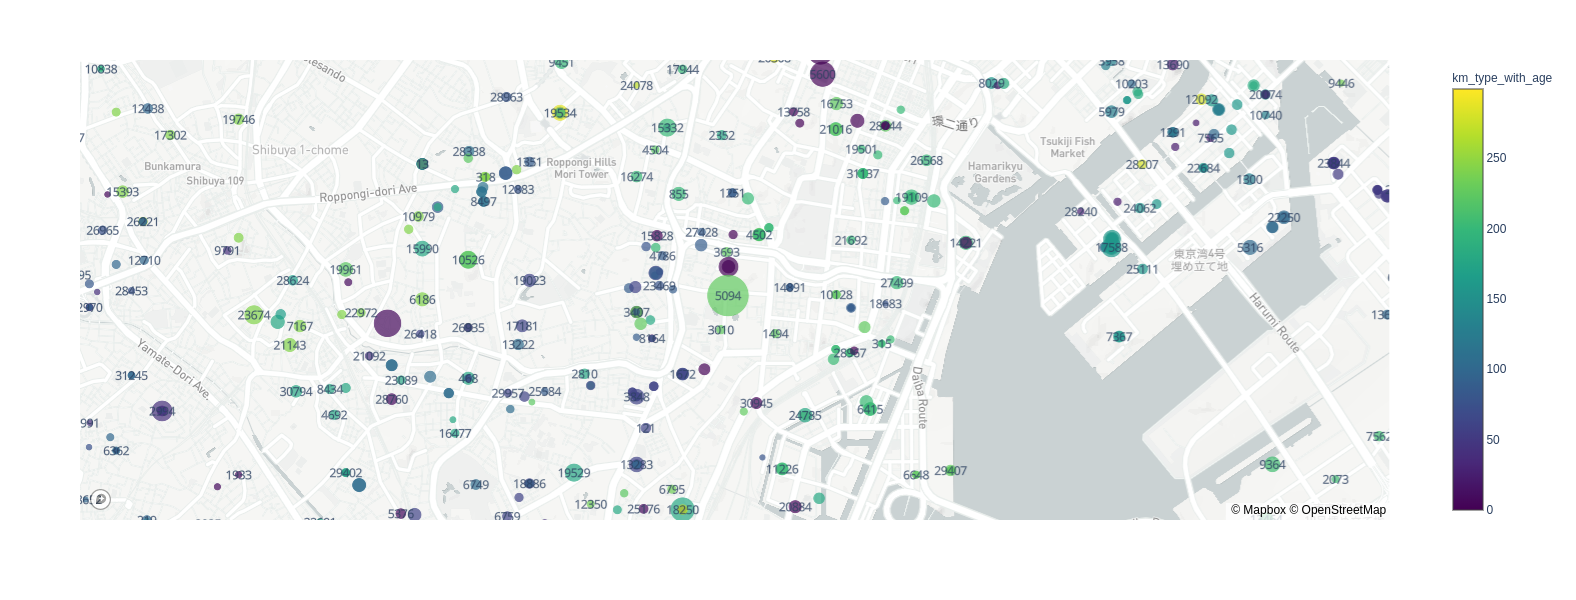

In [54]:
import plotly.express as px

px.set_mapbox_access_token('pk.eyJ1IjoiemVyZWJvbSIsImEiOiJjanpjY2JkZWUwMHMwM2RwNmQyanM2cHg4In0.VvajXw6UybbJhgp_-fHeYw')
fig = px.scatter_mapbox(mini_train, lat="loc_lat", lon="loc_lon",  color="km_type_with_age", size="賃料",text='id',
                  color_continuous_scale=px.colors.sequential.Viridis, size_max=30, zoom=10)
fig.show()

In [35]:
X_train['地価']=X_train['賃料']/X_train['面積']

In [36]:
def feature_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingを重要な列（面積など）でやる。TEと違って、test_dfに含まれる値も集計して作る'''
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

### target_encoding

In [37]:
def target_encoding(train, test, category_col, target_col, func_list):
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = train.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test


category_col='km_type_with_age'

target_dict = {category_col: ['mean']}
target_col = '地価'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']

### feature_encoding

In [38]:

X_train['地価'] = X_train['賃料'] / X_train['面積']
target_dict = {category_col: ['mean']}
target_col = '面積'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['area_diff'] = X_train['面積'] - X_train[f'{category_col}_面積_mean']
X_train['area_ratio'] = X_train['面積'] / X_train[f'{category_col}_面積_mean']
X_test['area_diff'] = X_test['面積'] - X_test[f'{category_col}_面積_mean']
X_test['area_ratio'] = X_test['面積'] / X_test[f'{category_col}_面積_mean']

target_dict = {category_col: ['mean']}
target_col = '築年数'
for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, target_col, func_list)

X_train['age_diff'] = X_train['築年数'] - X_train[f'{category_col}_築年数_mean']
X_train['age_ratio'] = X_train['築年数'] / X_train[f'{category_col}_築年数_mean']
X_test['age_diff'] = X_test['築年数'] - X_test[f'{category_col}_築年数_mean']
X_test['age_ratio'] = X_test['築年数'] / X_test[f'{category_col}_築年数_mean']
X_train['area/ageratio'] = X_train['area_ratio'] / X_train['age_ratio']
X_test['area/ageratio'] = X_test['area_ratio'] / X_test['age_ratio']

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']
X_train['地価x面積/築年数ratio'] = X_train['地価x面積'] / X_train['age_ratio']
X_test['地価x面積/築年数ratio'] = X_test['地価x面積'] / X_test['age_ratio']


In [39]:
X_train.columns

Index(['契約期間', '建物構造', '所在階', '方角', '築年数', '賃料', '間取り', '面積', '駐車場', '共同バス',
       ...
       'km_type_with_age_地価_mean', '地価x面積', 'km_type_with_age_面積_mean',
       'area_diff', 'area_ratio', 'km_type_with_age_築年数_mean', 'age_diff',
       'age_ratio', 'area/ageratio', '地価x面積/築年数ratio'],
      dtype='object', length=212)

In [40]:
# def get_loc_type(data,out_col='loc_type'):
#     '''緯度経度による、グリッドを作成'''
#     data2=data.copy()
#     data2[out_col]=0
#     count=0
#     for i in range(1,12):
#         for j in range(11):
#             data2.loc[data2.query(f'139.56+{i*0.03}<loc_lon<139.56+{(i+1)*0.03}&35.53+{j*0.03}<loc_lat<35.53+{(j+i)*0.03}').index.values,out_col]=count
#             print(count,end='')
#             print(data2.query(f'139.56+{i*0.03}<loc_lon<139.56+{(i+1)*0.03}&35.53+{j*0.03}<loc_lat<35.53+{(j+i)*0.03}').index.shape)
#             count+=1
#     return data2

# X_train['loc_type']=get_loc_type(X_train)
# X_test['loc_type']=get_loc_type(X_test)

In [41]:
# train['loc_type']
# sns.factorplot('Pclass','Survived',hue='Sex',data=train)

In [42]:
# loc_df=pd.DataFrame()
# loc_df['train']=train['loc_type'].value_counts()
# loc_df['test']=test['loc_type'].value_counts()
# loc_df.plot.scatter(0,1)
# plt.title('trainとtestのloc_typeの分布が同じことを確認')
# plt.show()


### make clusuter

In [43]:
# X = X_train[['loc_lat','loc_lon']]

# from sklearn.cluster import KMeans
# pred = KMeans(n_clusters=300).fit_predict(X)
# X['cluster'] = pred

In [44]:
# def plot_scatter(oof,train_y):
#     print('RMSE : ', np.sqrt(mean_squared_error(oof,train_y)))
#     print('R^2 : ', r2_score(oof,train_y))
#     plt.figure()
#     plt.scatter(oof,train_y, alpha=0.7)
#     plt.title("$R^2 = {:<.5}$".format(r2_score(oof,train_y)))
#     x = np.linspace(0, 2500000, 100)
#     plt.plot(x, x, c="indianred")
#     plt.xlabel('predict', size=20)
#     plt.ylabel('correct', size=20)
#     plt.show()
# plot_scatter(X_train['地価x面積'],y_train)

In [45]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'
lgbm_log_params['learning_rate']=0.05

lgbm_x_params=lgbm_params.copy()
lgbm_x_params['metric']='cross_entropy'
lgbm_x_params['learning_rate']=0.05


### xent_predict

In [49]:
# features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','loc_type_地価_mean',
#              '地価x面積', 'area_diff','area_ratio', 'age_diff', 'age_ratio','area/ageratio', '地価x面積/築年数ratio']

features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','km_type_with_age_地価_mean', '地価x面積', 'area_diff',
       'area_ratio', 'age_diff', 'age_ratio',
       'area/ageratio', '地価x面積/築年数ratio']
X_train = X_train[features]
X_test = X_test[features]

In [50]:
class TERegressionPredictor(RegressionPredictor):
    '''学習時に目的変数を変換するときに使う。例えばlogを取ってから学習する場合など。
         revertには逆操作となる関数を定義する。    
    '''
    def __init__(self, train_X, train_y, test_X, params=None, Folder=None, sk_model=None, n_splits=5, clf_type='xgb', aggfunc_dict=None, verbose_eval=5000, func=np.log1p, revert_func=np.expm1):
        self.func=func
        self.revert_func=revert_func
        super(LogRegressionPredictor, self).__init__(train_X, self.func(train_y), test_X, params,
                                                     Folder, sk_model, n_splits, clf_type, aggfunc_dict, verbose_eval)
    def target_encoding(self, tr_X, val_X, tr_y):
        '''CVとTEのfoldを同じにした。
        test,valのTEはtr_Xの情報のみで作られる。
        self.testが更新されるが、毎回のCVで上書きされる
        TODO:後からTEを取り出せるようにする。
        '''
        tr_X['target'] = tr_y
        for category_col, func_list in self.aggfunc_dict.items():
            agg_func = {'target': func_list}
            #agg_funcでgruopby
            agg_df = tr_X.groupby(category_col)['target'].agg(agg_func)
            #列名作成
            agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]

            #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
            #列名を追加する。
            if not set(agg_df.columns.values).issubset(set(self.columns)):
                self.columns = np.append(self.columns, agg_df.columns.values)
            for col in agg_df.columns.values:
                tr_X[col] = tr_X[category_col].map(agg_df[col]).copy()
                val_X[col] = val_X[category_col].map(agg_df[col]).copy()
                self.test_X[col] = self.test_X[category_col].map(agg_df[col]).copy()
        tr_X.drop(columns='target', inplace=True)
        return tr_X, val_X

In [51]:
xent_func= lambda x:np.log1p(x)/np.log1p(x.max())
xent_refunc= lambda x:np.expm1(x*14.731801689838349)

XLGBM = LogRegressionPredictor(X_train, y_train, X_test, Folder=folder, params=lgbm_x_params,
                                      sk_model=None, n_splits=10, clf_type='lgb',func=xent_func,revert_func=xent_refunc)
xlgboof, xlgbpreds, xlgbFIs = XLGBM.fit()
XLGBM.plot_FI(50)
XLGBM.plot_pred_dist()
XLGBM.plot_scatter_oofvspred()

Training on fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2292]	training's xentropy: 0.517743	valid_1's xentropy: 0.518762
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1441]	training's xentropy: 0.517746	valid_1's xentropy: 0.520082
Training on fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2185]	training's xentropy: 0.517831	valid_1's xentropy: 0.510222
Training on fold 4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2877]	training's xentropy: 0.517724	valid_1's xentropy: 0.520059
Training on fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2261]	training's xentropy: 0.517753	valid_1's xentropy: 0.517889
Training on fold 6
Training until validation scores don't improve for 50 rounds.
[5000]	tr

KeyboardInterrupt: 

### normal_predict

In [305]:
save_data(X_train,xlgboof, xlgbpreds,rmse=XLGBM.rmse(),name='xent_tika_km_col',save_dir='./stacking')

,id,target
0,31471,131716.898689
1,31472,118144.969809
2,31473,75672.612840
3,31474,61398.192711
4,31475,97812.009639


,id,target
0,1,81858.142987
1,2,58915.926401
2,3,109344.784345
3,4,175971.414982
4,5,62708.364295


Training on fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3228]	training's rmse: 10520.7	valid_1's rmse: 16163.1
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2295]	training's rmse: 11170.5	valid_1's rmse: 19069.4
Training on fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1337]	training's rmse: 13211.7	valid_1's rmse: 15743.8
Training on fold 4
Training until validation scores don't improve for 50 rounds.
[5000]	training's rmse: 9196.2	valid_1's rmse: 13381.4
Early stopping, best iteration is:
[7242]	training's rmse: 7963.33	valid_1's rmse: 13018.1
Training on fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1387]	training's rmse: 12914	valid_1's rmse: 19241.7
Training on fold 6
Training until validation scores don't improve for 50 rounds.
Early 

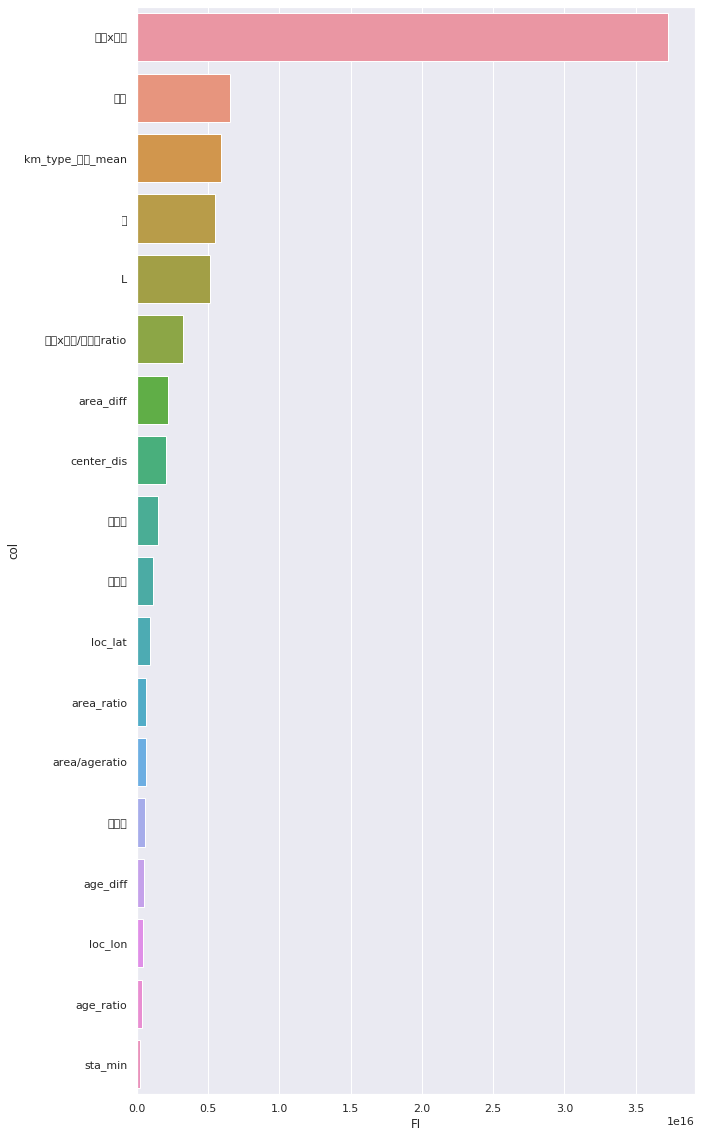

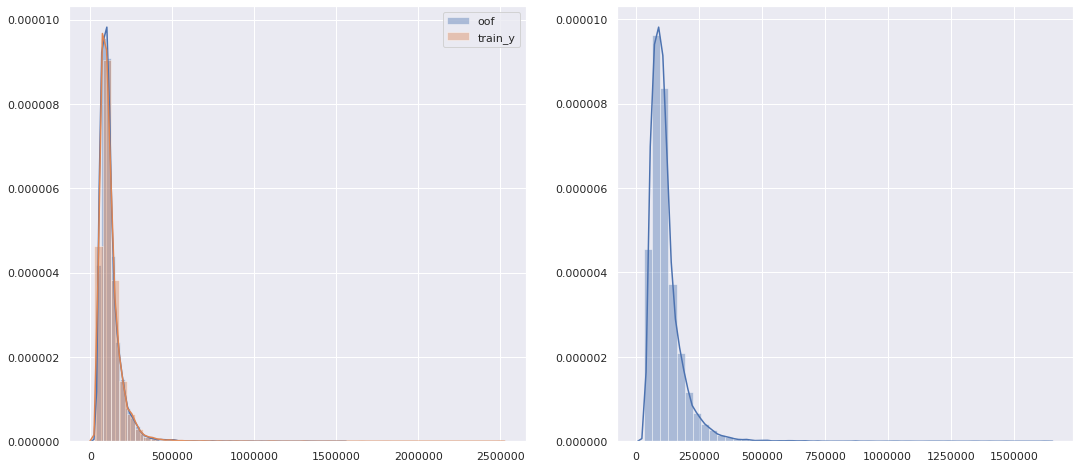

RMSE :  17143.949959276906
R^2 :  0.9411925923602866


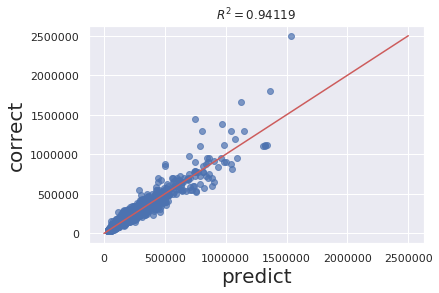

In [306]:
LGBM = RegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = LGBM.fit()
LGBM.plot_FI(50)
LGBM.plot_pred_dist()
LGBM.plot_scatter_oofvspred()

In [308]:
save_data(X_train,lgboof, lgbpreds,rmse=LGBM.rmse(),name='tika_kmcol',save_dir='./stacking')

,id,target
0,31471,134378.682255
1,31472,113087.628161
2,31473,72532.107663
3,31474,63063.236768
4,31475,118650.740952


,id,target
0,1,81965.541979
1,2,66042.822173
2,3,103919.686359
3,4,168036.605376
4,5,71642.266041


### log_predict

Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0202293	valid_1's l1: 0.0558849
[10000]	training's l1: 0.00985887	valid_1's l1: 0.0532088
[15000]	training's l1: 0.00580013	valid_1's l1: 0.0522901
Early stopping, best iteration is:
[18637]	training's l1: 0.00420373	valid_1's l1: 0.0519396
Training on fold 2
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0201767	valid_1's l1: 0.0535103
Early stopping, best iteration is:
[9483]	training's l1: 0.0104717	valid_1's l1: 0.0513229
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0202238	valid_1's l1: 0.0562345
[10000]	training's l1: 0.00998505	valid_1's l1: 0.0534617
[15000]	training's l1: 0.00588847	valid_1's l1: 0.0524313
Early stopping, best iteration is:
[16254]	training's l1: 0.00528906	valid_1's l1: 0.0522873
Training on fold 4
Training until validation scores don't improve for 50 rounds.

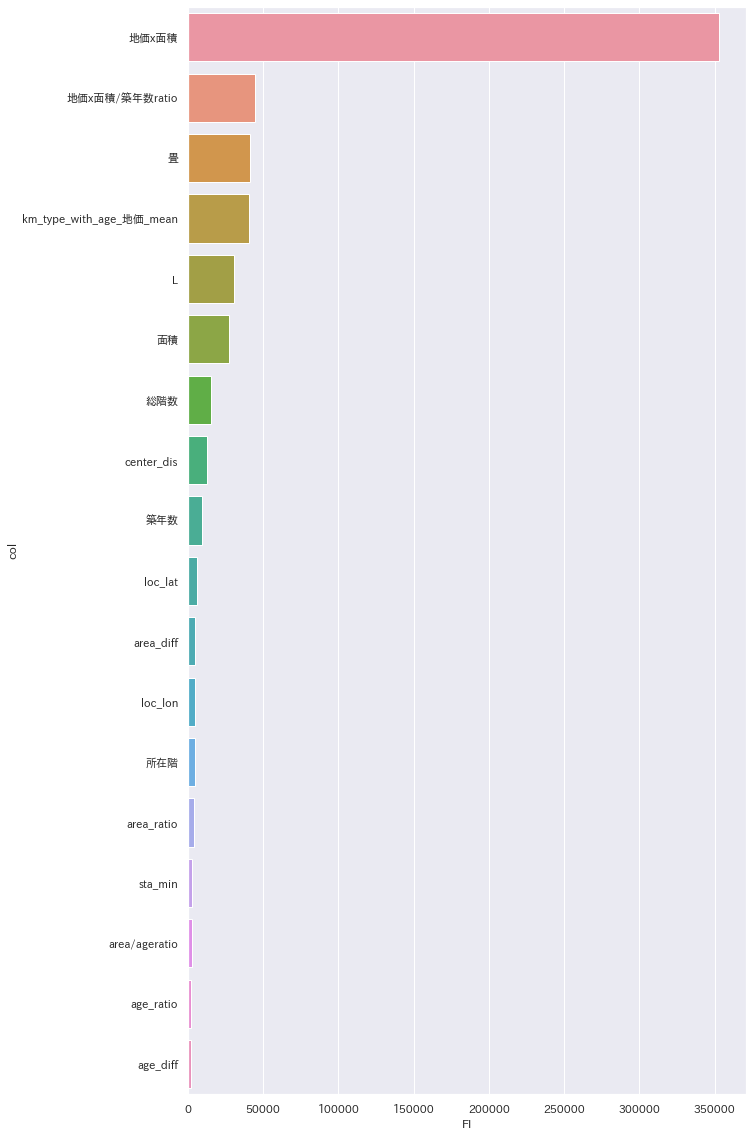

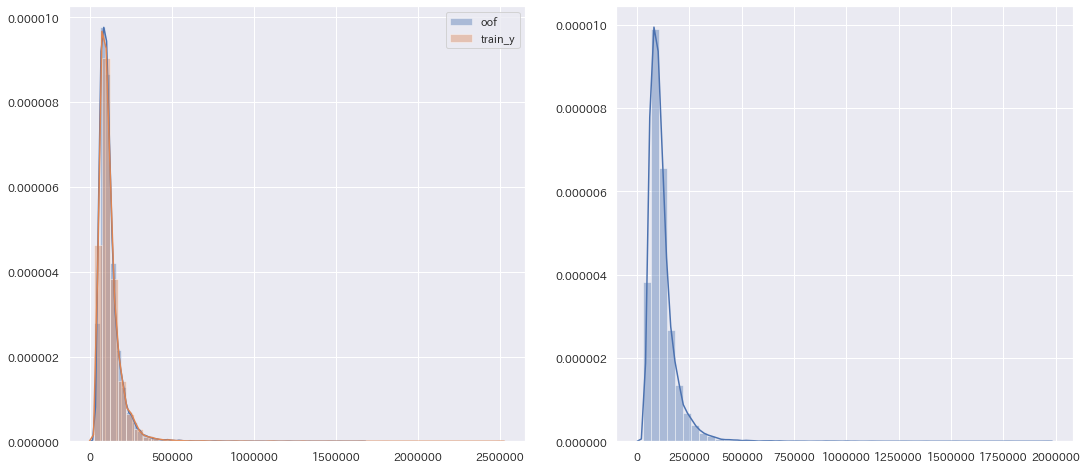

RMSE :  16208.568475390746
R^2 :  0.9477667990790297


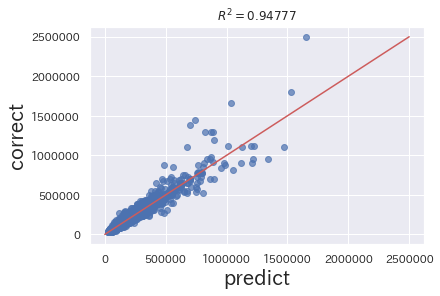

In [53]:
LogLGBM = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof, log_lgbpreds, log_lgbFIs = LogLGBM.fit()
LogLGBM.plot_FI(50)
LogLGBM.plot_pred_dist()
LogLGBM.plot_scatter_oofvspred()

In [359]:
def save_data(train,oof,preds,rmse=20000,name='lgb',submit_dir='./submit',save_dir='./submit'):
    '''stacking用にtrain,testの予測値を同じ形で保存する
    from pathlib import Path　がいる
    predict.csvの情報を記載したcsvも作成する
    '''
    submit_dir=Path(submit_dir)
    save_dir=Path(save_dir)
    submit_path=submit_dir/'sample_submit.csv'
    train_id_path=submit_dir/'train_id.csv'
    pred_path=save_dir/f'submit_{rmse}_{name}.csv'
    oof_path=save_dir/f'oof_{rmse}_{name}.csv'
    train_log_path=save_dir/f'pred_log.csv'
    
    submit = pd.read_csv(submit_path,header=None).rename(columns={0:'id',1:'target'})
    train_oof=pd.read_csv(train_id_path,header=None).rename(columns={0:'id',1:'target'})
    submit['target'] = preds
    train_oof['target']=oof
    submit.to_csv(pred_path, index=None, header=None)
    train_oof.to_csv(oof_path, index=None, header=None)
    
    if train_log_path.is_file():
        train_log_df=pd.read_csv(train_log_path)
    else:
        train_log_df=pd.DataFrame(columns=['path','features','rmse','time'])
    s=pd.Series([pred_path,','.join(train.columns),rmse,str(datetime.date.today())],index=['path','features','rmse','time'],name=train_log_df.shape[0])
    train_log_df=train_log_df.append(s)
    train_log_df.to_csv(train_log_path,index=None)
    
    display(submit.head())
    display(train_oof.head())

In [360]:
save_data(X_train,log_lgboof, log_lgbpreds,rmse=LogLGBM.rmse(),name='log_tika_loc_type2',save_dir='./stacking')

,id,target
0,31471,132053.917433
1,31472,117256.666903
2,31473,75805.655838
3,31474,60408.675517
4,31475,104576.924170


,id,target
0,1,85764.494641
1,2,66001.551324
2,3,105966.359595
3,4,160027.116873
4,5,63334.636205


In [358]:
LogLGBM.rmse()

16202